In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import lightgbm as lgb

In [2]:
df = pd.read_csv('train.csv')

In [3]:
X_code = df.drop(['target'], axis=1).values
y = df['target'].values
X_code_train, X_code_val, y_train, y_val = train_test_split(X_code, y, test_size= 0.2, random_state=0, stratify=y)

X_train = X_code_train[:,1:].astype(np.float)
code_train = X_code_train[:,0]
X_val = X_code_val[:,1:].astype(np.float)
code_val = X_code_val[:,0]

In [4]:
cols = df.columns[2:]
df_train = pd.DataFrame(X_train, columns=cols)
se_code_train = pd.Series(code_train, name='ID_code')
se_y_train = pd.Series(y_train, name='target')
df_train = pd.concat([se_code_train, se_y_train, df_train], axis=1)

In [5]:
df_val = pd.DataFrame(X_val, columns=cols)
se_code_val = pd.Series(code_val, name='ID_code')
se_y_val = pd.Series(y_val, name='target')
df_val = pd.concat([se_code_val, se_y_val, df_val], axis=1)

In [17]:
df_post_train = pd.read_csv('train_posterior.csv')
df_post_val = pd.read_csv('val_posterior.csv')
df_post_test = pd.read_csv('test_posterior.csv')

df_lr_train = pd.read_csv('train_lr_score.csv')
df_lr_val = pd.read_csv('val_lr_score.csv')
df_lr_test = pd.read_csv('test_lr_score.csv')

In [18]:
df_test = pd.read_csv('test.csv')

In [19]:
del df_lr_train['target'], df_lr_val['target']

In [53]:
df_train_all = pd.merge(df_train, df_post_train)
df_train_all = pd.merge(df_train_all, df_lr_train)

df_val_all = pd.merge(df_val, df_post_val)
df_val_all = pd.merge(df_val_all, df_lr_val)

df_test_all = pd.merge(df_test, df_post_test)
df_test_all = pd.merge(df_test_all, df_lr_test)

In [81]:
X_train = df_train_all.drop(['ID_code','target'], axis=1).values
y_train = df_train_all['target'].values

X_val = df_val_all.drop(['ID_code','target'], axis=1).values
y_val = df_val_all['target'].values

X_test = df_test_all.drop(['ID_code'], axis=1).values

In [88]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [28]:
import optuna

In [41]:
def objective(trial):
    """最小化する目的関数"""
    # LightGBM parameters
    params = {
        'objective': 'binary',
        'boost_from_average':False,
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0), # 1.0 use
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 1.0), # small for acc
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100), # 20 use
        'min_sum_hessian_in_leaf' : trial.suggest_uniform('min_sum_hessian_in_leaf', 1e-4, 1e-2) ,#1e-3 use
        'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0.8, 1.0) ,# 1.0 use
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10) ,# 0 use
        'min_gain_to_split': trial.suggest_uniform('min_gain_to_split', 0.8, 1.0),# 0.0 use
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0, 0.5),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0, 0.5),
        'num_leaves'   : trial.suggest_int('num_leaves', 16, 31), # 31, small for overfit, large for acc
        'max_bin': trial.suggest_int('max_bin', 128, 255), # 255, small for overfit, large for acc, 
    }
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_val,
                    num_boost_round=10000,
                    early_stopping_rounds=100,
                    verbose_eval = 200)    
    
    y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred)
    auc_val = metrics.auc(fpr_val, tpr_val)
    return  -auc_val

In [42]:
study = optuna.create_study()
study.optimize(objective, n_trials=500)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's auc: 0.876988


[I 2019-04-07 23:22:30,465] Finished trial#0 resulted in value: -0.8769877751321217. Current best value is -0.8769877751321217 with parameters: {'feature_fraction': 0.9753787985168908, 'learning_rate': 0.22632436999607605, 'subsample': 0.8084205654587784, 'min_data_in_leaf': 51, 'min_sum_hessian_in_leaf': 0.0007012267031058061, 'bagging_fraction': 0.9975356344507997, 'bagging_freq': 9, 'min_gain_to_split': 0.8658423742125327, 'lambda_l1': 0.03758254444538933, 'lambda_l2': 0.3445764950755816, 'num_leaves': 27, 'max_bin': 181}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's auc: 0.869367


[I 2019-04-07 23:22:51,340] Finished trial#1 resulted in value: -0.8693671096988653. Current best value is -0.8769877751321217 with parameters: {'feature_fraction': 0.9753787985168908, 'learning_rate': 0.22632436999607605, 'subsample': 0.8084205654587784, 'min_data_in_leaf': 51, 'min_sum_hessian_in_leaf': 0.0007012267031058061, 'bagging_fraction': 0.9975356344507997, 'bagging_freq': 9, 'min_gain_to_split': 0.8658423742125327, 'lambda_l1': 0.03758254444538933, 'lambda_l2': 0.3445764950755816, 'num_leaves': 27, 'max_bin': 181}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[21]	valid_0's auc: 0.868099


[I 2019-04-07 23:23:06,259] Finished trial#2 resulted in value: -0.8680991028736252. Current best value is -0.8769877751321217 with parameters: {'feature_fraction': 0.9753787985168908, 'learning_rate': 0.22632436999607605, 'subsample': 0.8084205654587784, 'min_data_in_leaf': 51, 'min_sum_hessian_in_leaf': 0.0007012267031058061, 'bagging_fraction': 0.9975356344507997, 'bagging_freq': 9, 'min_gain_to_split': 0.8658423742125327, 'lambda_l1': 0.03758254444538933, 'lambda_l2': 0.3445764950755816, 'num_leaves': 27, 'max_bin': 181}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	valid_0's auc: 0.870821


[I 2019-04-07 23:23:19,648] Finished trial#3 resulted in value: -0.870820999228427. Current best value is -0.8769877751321217 with parameters: {'feature_fraction': 0.9753787985168908, 'learning_rate': 0.22632436999607605, 'subsample': 0.8084205654587784, 'min_data_in_leaf': 51, 'min_sum_hessian_in_leaf': 0.0007012267031058061, 'bagging_fraction': 0.9975356344507997, 'bagging_freq': 9, 'min_gain_to_split': 0.8658423742125327, 'lambda_l1': 0.03758254444538933, 'lambda_l2': 0.3445764950755816, 'num_leaves': 27, 'max_bin': 181}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[37]	valid_0's auc: 0.871983


[I 2019-04-07 23:23:36,370] Finished trial#4 resulted in value: -0.8719829147757597. Current best value is -0.8769877751321217 with parameters: {'feature_fraction': 0.9753787985168908, 'learning_rate': 0.22632436999607605, 'subsample': 0.8084205654587784, 'min_data_in_leaf': 51, 'min_sum_hessian_in_leaf': 0.0007012267031058061, 'bagging_fraction': 0.9975356344507997, 'bagging_freq': 9, 'min_gain_to_split': 0.8658423742125327, 'lambda_l1': 0.03758254444538933, 'lambda_l2': 0.3445764950755816, 'num_leaves': 27, 'max_bin': 181}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.877863
[400]	valid_0's auc: 0.88354
[600]	valid_0's auc: 0.884997
[800]	valid_0's auc: 0.885414
Early stopping, best iteration is:
[766]	valid_0's auc: 0.885583


[I 2019-04-07 23:25:55,811] Finished trial#5 resulted in value: -0.8855830630062582. Current best value is -0.8855830630062582 with parameters: {'feature_fraction': 0.9632769705131796, 'learning_rate': 0.04451690910588942, 'subsample': 0.9482494759019763, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.0071531850104952655, 'bagging_fraction': 0.9219664039258519, 'bagging_freq': 10, 'min_gain_to_split': 0.866114331697275, 'lambda_l1': 0.32513006918916015, 'lambda_l2': 0.17950422582364367, 'num_leaves': 30, 'max_bin': 232}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid_0's auc: 0.867692


[I 2019-04-07 23:26:07,527] Finished trial#6 resulted in value: -0.8676919633350757. Current best value is -0.8855830630062582 with parameters: {'feature_fraction': 0.9632769705131796, 'learning_rate': 0.04451690910588942, 'subsample': 0.9482494759019763, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.0071531850104952655, 'bagging_fraction': 0.9219664039258519, 'bagging_freq': 10, 'min_gain_to_split': 0.866114331697275, 'lambda_l1': 0.32513006918916015, 'lambda_l2': 0.17950422582364367, 'num_leaves': 30, 'max_bin': 232}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[11]	valid_0's auc: 0.866354


[I 2019-04-07 23:26:19,816] Finished trial#7 resulted in value: -0.8663544700068307. Current best value is -0.8855830630062582 with parameters: {'feature_fraction': 0.9632769705131796, 'learning_rate': 0.04451690910588942, 'subsample': 0.9482494759019763, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.0071531850104952655, 'bagging_fraction': 0.9219664039258519, 'bagging_freq': 10, 'min_gain_to_split': 0.866114331697275, 'lambda_l1': 0.32513006918916015, 'lambda_l2': 0.17950422582364367, 'num_leaves': 30, 'max_bin': 232}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[16]	valid_0's auc: 0.867063


[I 2019-04-07 23:26:32,295] Finished trial#8 resulted in value: -0.8670629205279881. Current best value is -0.8855830630062582 with parameters: {'feature_fraction': 0.9632769705131796, 'learning_rate': 0.04451690910588942, 'subsample': 0.9482494759019763, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.0071531850104952655, 'bagging_fraction': 0.9219664039258519, 'bagging_freq': 10, 'min_gain_to_split': 0.866114331697275, 'lambda_l1': 0.32513006918916015, 'lambda_l2': 0.17950422582364367, 'num_leaves': 30, 'max_bin': 232}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[17]	valid_0's auc: 0.862843


[I 2019-04-07 23:26:44,022] Finished trial#9 resulted in value: -0.8628426862353048. Current best value is -0.8855830630062582 with parameters: {'feature_fraction': 0.9632769705131796, 'learning_rate': 0.04451690910588942, 'subsample': 0.9482494759019763, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.0071531850104952655, 'bagging_fraction': 0.9219664039258519, 'bagging_freq': 10, 'min_gain_to_split': 0.866114331697275, 'lambda_l1': 0.32513006918916015, 'lambda_l2': 0.17950422582364367, 'num_leaves': 30, 'max_bin': 232}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.854262
[400]	valid_0's auc: 0.856834
[600]	valid_0's auc: 0.857846
[800]	valid_0's auc: 0.858748
[1000]	valid_0's auc: 0.859449
[1200]	valid_0's auc: 0.860117
[1400]	valid_0's auc: 0.860759
[1600]	valid_0's auc: 0.861261
[1800]	valid_0's auc: 0.8618
[2000]	valid_0's auc: 0.862445
[2200]	valid_0's auc: 0.863134
[2400]	valid_0's auc: 0.863886
[2600]	valid_0's auc: 0.864764
[2800]	valid_0's auc: 0.865777
[3000]	valid_0's auc: 0.866791
[3200]	valid_0's auc: 0.867833
[3400]	valid_0's auc: 0.868814
[3600]	valid_0's auc: 0.869701
[3800]	valid_0's auc: 0.870514
[4000]	valid_0's auc: 0.871276
[4200]	valid_0's auc: 0.872064
[4400]	valid_0's auc: 0.87283
[4600]	valid_0's auc: 0.873578
[4800]	valid_0's auc: 0.874246
[5000]	valid_0's auc: 0.874866
[5200]	valid_0's auc: 0.875453
[5400]	valid_0's auc: 0.875984
[5600]	valid_0's auc: 0.876493
[5800]	valid_0's auc: 0.87695
[6000]	valid_0's auc: 0.877366
[6200]	valid_0'

[I 2019-04-07 23:52:16,086] Finished trial#10 resulted in value: -0.8827784852834218. Current best value is -0.8855830630062582 with parameters: {'feature_fraction': 0.9632769705131796, 'learning_rate': 0.04451690910588942, 'subsample': 0.9482494759019763, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.0071531850104952655, 'bagging_fraction': 0.9219664039258519, 'bagging_freq': 10, 'min_gain_to_split': 0.866114331697275, 'lambda_l1': 0.32513006918916015, 'lambda_l2': 0.17950422582364367, 'num_leaves': 30, 'max_bin': 232}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.878563
Early stopping, best iteration is:
[250]	valid_0's auc: 0.878953


[I 2019-04-07 23:53:09,311] Finished trial#11 resulted in value: -0.8789531428460811. Current best value is -0.8855830630062582 with parameters: {'feature_fraction': 0.9632769705131796, 'learning_rate': 0.04451690910588942, 'subsample': 0.9482494759019763, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.0071531850104952655, 'bagging_fraction': 0.9219664039258519, 'bagging_freq': 10, 'min_gain_to_split': 0.866114331697275, 'lambda_l1': 0.32513006918916015, 'lambda_l2': 0.17950422582364367, 'num_leaves': 30, 'max_bin': 232}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881261
[400]	valid_0's auc: 0.883754
Early stopping, best iteration is:
[432]	valid_0's auc: 0.884097


[I 2019-04-07 23:54:29,035] Finished trial#12 resulted in value: -0.8840973288089844. Current best value is -0.8855830630062582 with parameters: {'feature_fraction': 0.9632769705131796, 'learning_rate': 0.04451690910588942, 'subsample': 0.9482494759019763, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.0071531850104952655, 'bagging_fraction': 0.9219664039258519, 'bagging_freq': 10, 'min_gain_to_split': 0.866114331697275, 'lambda_l1': 0.32513006918916015, 'lambda_l2': 0.17950422582364367, 'num_leaves': 30, 'max_bin': 232}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.860758
[400]	valid_0's auc: 0.869053
[600]	valid_0's auc: 0.875281
[800]	valid_0's auc: 0.87868
[1000]	valid_0's auc: 0.880845
[1200]	valid_0's auc: 0.882326
[1400]	valid_0's auc: 0.883465
[1600]	valid_0's auc: 0.884519
[1800]	valid_0's auc: 0.885203
[2000]	valid_0's auc: 0.886003
[2200]	valid_0's auc: 0.886297
[2400]	valid_0's auc: 0.88668
[2600]	valid_0's auc: 0.886981
[2800]	valid_0's auc: 0.887179
Early stopping, best iteration is:
[2813]	valid_0's auc: 0.887204


[I 2019-04-08 00:00:54,680] Finished trial#13 resulted in value: -0.8872043548239902. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[9]	valid_0's auc: 0.856569


[I 2019-04-08 00:01:04,398] Finished trial#14 resulted in value: -0.8565687474246334. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.875377
Early stopping, best iteration is:
[101]	valid_0's auc: 0.877775


[I 2019-04-08 00:01:27,494] Finished trial#15 resulted in value: -0.8777749731055673. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.878954
Early stopping, best iteration is:
[157]	valid_0's auc: 0.879929


[I 2019-04-08 00:01:58,867] Finished trial#16 resulted in value: -0.8799289613632783. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.864697
[400]	valid_0's auc: 0.875088
[600]	valid_0's auc: 0.879453
[800]	valid_0's auc: 0.882107
[1000]	valid_0's auc: 0.883869
[1200]	valid_0's auc: 0.884878
[1400]	valid_0's auc: 0.885524
[1600]	valid_0's auc: 0.885851
Early stopping, best iteration is:
[1687]	valid_0's auc: 0.886008


[I 2019-04-08 00:06:29,262] Finished trial#17 resulted in value: -0.8860082577661996. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.855732
[400]	valid_0's auc: 0.858007
[600]	valid_0's auc: 0.859761
[800]	valid_0's auc: 0.861132
[1000]	valid_0's auc: 0.862459
[1200]	valid_0's auc: 0.864197
[1400]	valid_0's auc: 0.866174
[1600]	valid_0's auc: 0.868328
[1800]	valid_0's auc: 0.870027
[2000]	valid_0's auc: 0.871774
[2200]	valid_0's auc: 0.873456
[2400]	valid_0's auc: 0.874841
[2600]	valid_0's auc: 0.875852
[2800]	valid_0's auc: 0.876755
[3000]	valid_0's auc: 0.87763
[3200]	valid_0's auc: 0.878385
[3400]	valid_0's auc: 0.879045
[3600]	valid_0's auc: 0.879699
[3800]	valid_0's auc: 0.880309
[4000]	valid_0's auc: 0.880713
[4200]	valid_0's auc: 0.881265
[4400]	valid_0's auc: 0.881703
[4600]	valid_0's auc: 0.88207
[4800]	valid_0's auc: 0.882412
[5000]	valid_0's auc: 0.882788
[5200]	valid_0's auc: 0.883079
[5400]	valid_0's auc: 0.883368
[5600]	valid_0's auc: 0.883629
[5800]	valid_0's auc: 0.883896
[6000]	valid_0's auc: 0.884189
[6200]	valid_

[I 2019-04-08 00:31:00,137] Finished trial#18 resulted in value: -0.8866162102218205. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[23]	valid_0's auc: 0.869557


[I 2019-04-08 00:31:18,343] Finished trial#19 resulted in value: -0.8695574725040722. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[19]	valid_0's auc: 0.869876


[I 2019-04-08 00:31:35,474] Finished trial#20 resulted in value: -0.8698760298009673. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[14]	valid_0's auc: 0.865603


[I 2019-04-08 00:31:49,022] Finished trial#21 resulted in value: -0.8656025390003843. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[9]	valid_0's auc: 0.856661


[I 2019-04-08 00:32:00,664] Finished trial#22 resulted in value: -0.8566611080229758. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[50]	valid_0's auc: 0.87095


[I 2019-04-08 00:32:23,538] Finished trial#23 resulted in value: -0.87094996805854. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[29]	valid_0's auc: 0.870563


[I 2019-04-08 00:32:36,617] Finished trial#24 resulted in value: -0.8705627158814043. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881236
Early stopping, best iteration is:
[228]	valid_0's auc: 0.881742


[I 2019-04-08 00:33:19,315] Finished trial#25 resulted in value: -0.8817420125608756. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[14]	valid_0's auc: 0.865214


[I 2019-04-08 00:33:34,562] Finished trial#26 resulted in value: -0.8652144917436165. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[7]	valid_0's auc: 0.856142


[I 2019-04-08 00:33:45,377] Finished trial#27 resulted in value: -0.8561417412658775. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.873548
Early stopping, best iteration is:
[113]	valid_0's auc: 0.875122


[I 2019-04-08 00:34:13,490] Finished trial#28 resulted in value: -0.8751220066980274. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881177
[400]	valid_0's auc: 0.8813
Early stopping, best iteration is:
[318]	valid_0's auc: 0.88214


[I 2019-04-08 00:35:02,376] Finished trial#29 resulted in value: -0.8821398220127822. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.877049
Early stopping, best iteration is:
[114]	valid_0's auc: 0.877185


[I 2019-04-08 00:35:29,656] Finished trial#30 resulted in value: -0.8771850516732624. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[35]	valid_0's auc: 0.870637


[I 2019-04-08 00:35:46,311] Finished trial#31 resulted in value: -0.8706365200125. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	valid_0's auc: 0.865098


[I 2019-04-08 00:35:57,562] Finished trial#32 resulted in value: -0.8650979054145614. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[27]	valid_0's auc: 0.870862


[I 2019-04-08 00:36:13,230] Finished trial#33 resulted in value: -0.8708616105133034. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[41]	valid_0's auc: 0.87328


[I 2019-04-08 00:36:30,096] Finished trial#34 resulted in value: -0.8732798210172041. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[17]	valid_0's auc: 0.8669


[I 2019-04-08 00:36:44,146] Finished trial#35 resulted in value: -0.8669002334077253. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.877063
[400]	valid_0's auc: 0.883156
[600]	valid_0's auc: 0.885251
[800]	valid_0's auc: 0.885692
Early stopping, best iteration is:
[838]	valid_0's auc: 0.885859


[I 2019-04-08 00:38:41,276] Finished trial#36 resulted in value: -0.88585884501893. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid_0's auc: 0.864084


[I 2019-04-08 00:38:56,071] Finished trial#37 resulted in value: -0.8640841857969739. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[26]	valid_0's auc: 0.867365


[I 2019-04-08 00:39:12,367] Finished trial#38 resulted in value: -0.8673645737405248. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	valid_0's auc: 0.868928


[I 2019-04-08 00:39:27,622] Finished trial#39 resulted in value: -0.8689276035055408. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[11]	valid_0's auc: 0.855915


[I 2019-04-08 00:39:36,563] Finished trial#40 resulted in value: -0.8559150606058091. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[9]	valid_0's auc: 0.862364


[I 2019-04-08 00:39:47,049] Finished trial#41 resulted in value: -0.8623638236001758. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's auc: 0.87673


[I 2019-04-08 00:40:07,617] Finished trial#42 resulted in value: -0.8767296853697051. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid_0's auc: 0.862244


[I 2019-04-08 00:40:19,992] Finished trial#43 resulted in value: -0.8622443922687839. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881548
[400]	valid_0's auc: 0.884315
Early stopping, best iteration is:
[410]	valid_0's auc: 0.884357


[I 2019-04-08 00:41:16,385] Finished trial#44 resulted in value: -0.8843569257658345. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.858025
[400]	valid_0's auc: 0.860533
[600]	valid_0's auc: 0.862076
[800]	valid_0's auc: 0.864446
[1000]	valid_0's auc: 0.867574
[1200]	valid_0's auc: 0.870476
[1400]	valid_0's auc: 0.872964
[1600]	valid_0's auc: 0.875167
[1800]	valid_0's auc: 0.876714
[2000]	valid_0's auc: 0.878071
[2200]	valid_0's auc: 0.87922
[2400]	valid_0's auc: 0.880182
[2600]	valid_0's auc: 0.880962
[2800]	valid_0's auc: 0.881705
[3000]	valid_0's auc: 0.882372
[3200]	valid_0's auc: 0.882912
[3400]	valid_0's auc: 0.883394
[3600]	valid_0's auc: 0.883739
[3800]	valid_0's auc: 0.884222
[4000]	valid_0's auc: 0.884507
[4200]	valid_0's auc: 0.884824
[4400]	valid_0's auc: 0.88517
[4600]	valid_0's auc: 0.885383
[4800]	valid_0's auc: 0.88563
[5000]	valid_0's auc: 0.885856
[5200]	valid_0's auc: 0.886035
[5400]	valid_0's auc: 0.886162
[5600]	valid_0's auc: 0.886325
[5800]	valid_0's auc: 0.886469
[6000]	valid_0's auc: 0.886642
[6200]	valid_0

[I 2019-04-08 00:54:50,324] Finished trial#45 resulted in value: -0.8870155061269528. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.875515
Early stopping, best iteration is:
[117]	valid_0's auc: 0.877105


[I 2019-04-08 00:55:15,600] Finished trial#46 resulted in value: -0.8771049836974106. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[11]	valid_0's auc: 0.863487


[I 2019-04-08 00:55:25,035] Finished trial#47 resulted in value: -0.8634873022325836. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[30]	valid_0's auc: 0.872353


[I 2019-04-08 00:55:37,492] Finished trial#48 resulted in value: -0.8723526613735103. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[15]	valid_0's auc: 0.865644


[I 2019-04-08 00:55:49,402] Finished trial#49 resulted in value: -0.8656440870964798. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[8]	valid_0's auc: 0.860754


[I 2019-04-08 00:55:58,895] Finished trial#50 resulted in value: -0.8607536870953736. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880516
[400]	valid_0's auc: 0.884462
[600]	valid_0's auc: 0.884543
Early stopping, best iteration is:
[520]	valid_0's auc: 0.884863


[I 2019-04-08 00:57:15,098] Finished trial#51 resulted in value: -0.8848630942010349. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880259
Early stopping, best iteration is:
[195]	valid_0's auc: 0.88038


[I 2019-04-08 00:57:48,247] Finished trial#52 resulted in value: -0.8803802554763702. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.857689
[400]	valid_0's auc: 0.860557
[600]	valid_0's auc: 0.862271
[800]	valid_0's auc: 0.865111
[1000]	valid_0's auc: 0.86817
[1200]	valid_0's auc: 0.87111
[1400]	valid_0's auc: 0.873792
[1600]	valid_0's auc: 0.875859
[1800]	valid_0's auc: 0.877298
[2000]	valid_0's auc: 0.878517
[2200]	valid_0's auc: 0.879637
[2400]	valid_0's auc: 0.880685
[2600]	valid_0's auc: 0.881518
[2800]	valid_0's auc: 0.882353
[3000]	valid_0's auc: 0.882966
[3200]	valid_0's auc: 0.8835
[3400]	valid_0's auc: 0.883909
[3600]	valid_0's auc: 0.88445
[3800]	valid_0's auc: 0.88497
[4000]	valid_0's auc: 0.885268
[4200]	valid_0's auc: 0.88559
[4400]	valid_0's auc: 0.885914
[4600]	valid_0's auc: 0.886017
[4800]	valid_0's auc: 0.88625
[5000]	valid_0's auc: 0.886436
[5200]	valid_0's auc: 0.886603
[5400]	valid_0's auc: 0.88672
[5600]	valid_0's auc: 0.886848
[5800]	valid_0's auc: 0.886925
[6000]	valid_0's auc: 0.887028
[6200]	valid_0's auc

[I 2019-04-08 01:10:31,432] Finished trial#53 resulted in value: -0.8871333576696839. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[24]	valid_0's auc: 0.868491


[I 2019-04-08 01:10:46,595] Finished trial#54 resulted in value: -0.8684910356499881. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's auc: 0.874997


[I 2019-04-08 01:11:11,316] Finished trial#55 resulted in value: -0.874997497227592. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[50]	valid_0's auc: 0.872403


[I 2019-04-08 01:11:26,466] Finished trial#56 resulted in value: -0.8724031523870364. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[7]	valid_0's auc: 0.85698


[I 2019-04-08 01:11:35,365] Finished trial#57 resulted in value: -0.8569797240866264. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[9]	valid_0's auc: 0.857899


[I 2019-04-08 01:11:44,129] Finished trial#58 resulted in value: -0.857899143802942. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.875316
[400]	valid_0's auc: 0.882607
[600]	valid_0's auc: 0.884743
[800]	valid_0's auc: 0.885752
Early stopping, best iteration is:
[839]	valid_0's auc: 0.885929


[I 2019-04-08 01:13:34,636] Finished trial#59 resulted in value: -0.8859288742502054. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.8806
Early stopping, best iteration is:
[269]	valid_0's auc: 0.881508


[I 2019-04-08 01:14:23,897] Finished trial#60 resulted in value: -0.8815080793918125. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	valid_0's auc: 0.866936


[I 2019-04-08 01:14:38,669] Finished trial#61 resulted in value: -0.8669355625983479. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[20]	valid_0's auc: 0.867859


[I 2019-04-08 01:14:51,946] Finished trial#62 resulted in value: -0.867858504863122. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[20]	valid_0's auc: 0.86547


[I 2019-04-08 01:15:06,379] Finished trial#63 resulted in value: -0.8654704659028372. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.875896
Early stopping, best iteration is:
[160]	valid_0's auc: 0.876844


[I 2019-04-08 01:15:36,682] Finished trial#64 resulted in value: -0.8768436168241615. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.861276
[400]	valid_0's auc: 0.869224
[600]	valid_0's auc: 0.875908
[800]	valid_0's auc: 0.87926
[1000]	valid_0's auc: 0.881309
[1200]	valid_0's auc: 0.883064
[1400]	valid_0's auc: 0.884106
[1600]	valid_0's auc: 0.885044
[1800]	valid_0's auc: 0.885765
[2000]	valid_0's auc: 0.886172
[2200]	valid_0's auc: 0.886593
[2400]	valid_0's auc: 0.886922
[2600]	valid_0's auc: 0.887079
Early stopping, best iteration is:
[2574]	valid_0's auc: 0.887114


[I 2019-04-08 01:20:47,660] Finished trial#65 resulted in value: -0.8871143310683935. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.869348
[400]	valid_0's auc: 0.878943
[600]	valid_0's auc: 0.882678
[800]	valid_0's auc: 0.884438
[1000]	valid_0's auc: 0.885501
[1200]	valid_0's auc: 0.885835
[1400]	valid_0's auc: 0.886079
Early stopping, best iteration is:
[1471]	valid_0's auc: 0.886257


[I 2019-04-08 01:24:06,198] Finished trial#66 resulted in value: -0.8862566682983082. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880161
[400]	valid_0's auc: 0.882639
Early stopping, best iteration is:
[347]	valid_0's auc: 0.882845


[I 2019-04-08 01:24:57,996] Finished trial#67 resulted in value: -0.8828451267840896. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879522
Early stopping, best iteration is:
[195]	valid_0's auc: 0.879672


[I 2019-04-08 01:25:32,687] Finished trial#68 resulted in value: -0.8796718740925721. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.856632
[400]	valid_0's auc: 0.859118
[600]	valid_0's auc: 0.860558
[800]	valid_0's auc: 0.862033
[1000]	valid_0's auc: 0.863873
[1200]	valid_0's auc: 0.866417
[1400]	valid_0's auc: 0.868714
[1600]	valid_0's auc: 0.870794
[1800]	valid_0's auc: 0.872731
[2000]	valid_0's auc: 0.874409
[2200]	valid_0's auc: 0.875901
[2400]	valid_0's auc: 0.876979
[2600]	valid_0's auc: 0.877932
[2800]	valid_0's auc: 0.878771
[3000]	valid_0's auc: 0.879491
[3200]	valid_0's auc: 0.880198
[3400]	valid_0's auc: 0.880813
[3600]	valid_0's auc: 0.881302
[3800]	valid_0's auc: 0.88174
[4000]	valid_0's auc: 0.882073
[4200]	valid_0's auc: 0.882552
[4400]	valid_0's auc: 0.882931
[4600]	valid_0's auc: 0.883296
[4800]	valid_0's auc: 0.883707
[5000]	valid_0's auc: 0.88399
[5200]	valid_0's auc: 0.884267
[5400]	valid_0's auc: 0.884563
[5600]	valid_0's auc: 0.884819
[5800]	valid_0's auc: 0.885034
[6000]	valid_0's auc: 0.885197
[6200]	valid_

[I 2019-04-08 01:44:02,346] Finished trial#69 resulted in value: -0.8871093462647852. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[95]	valid_0's auc: 0.877069


[I 2019-04-08 01:44:29,104] Finished trial#70 resulted in value: -0.8770693986985584. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's auc: 0.874553


[I 2019-04-08 01:44:51,027] Finished trial#71 resulted in value: -0.8745533864861352. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[33]	valid_0's auc: 0.871637


[I 2019-04-08 01:45:06,729] Finished trial#72 resulted in value: -0.8716374561323456. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	valid_0's auc: 0.878245


[I 2019-04-08 01:45:32,559] Finished trial#73 resulted in value: -0.8782449481331531. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880206
[400]	valid_0's auc: 0.883226
Early stopping, best iteration is:
[422]	valid_0's auc: 0.883486


[I 2019-04-08 01:46:40,736] Finished trial#74 resulted in value: -0.8834864518430637. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880727
Early stopping, best iteration is:
[163]	valid_0's auc: 0.881006


[I 2019-04-08 01:47:09,115] Finished trial#75 resulted in value: -0.8810056028916008. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[99]	valid_0's auc: 0.87686


[I 2019-04-08 01:47:31,971] Finished trial#76 resulted in value: -0.8768595944679051. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.877287
Early stopping, best iteration is:
[115]	valid_0's auc: 0.877858


[I 2019-04-08 01:47:59,879] Finished trial#77 resulted in value: -0.8778580485565503. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.877331
[400]	valid_0's auc: 0.882661
[600]	valid_0's auc: 0.884941
[800]	valid_0's auc: 0.88536
Early stopping, best iteration is:
[731]	valid_0's auc: 0.885441


[I 2019-04-08 01:49:47,344] Finished trial#78 resulted in value: -0.8854406262185459. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880944
[400]	valid_0's auc: 0.881969
Early stopping, best iteration is:
[324]	valid_0's auc: 0.882956


[I 2019-04-08 01:50:50,562] Finished trial#79 resulted in value: -0.8829563134853802. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.872378
Early stopping, best iteration is:
[128]	valid_0's auc: 0.875187


[I 2019-04-08 01:51:18,960] Finished trial#80 resulted in value: -0.8751874521223786. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880566
Early stopping, best iteration is:
[296]	valid_0's auc: 0.881212


[I 2019-04-08 01:52:07,986] Finished trial#81 resulted in value: -0.8812115838262827. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.856313
[400]	valid_0's auc: 0.858265
[600]	valid_0's auc: 0.859174
[800]	valid_0's auc: 0.860049
[1000]	valid_0's auc: 0.86099
[1200]	valid_0's auc: 0.861793
[1400]	valid_0's auc: 0.862797
[1600]	valid_0's auc: 0.86396
[1800]	valid_0's auc: 0.865271
[2000]	valid_0's auc: 0.866694
[2200]	valid_0's auc: 0.868157
[2400]	valid_0's auc: 0.869503
[2600]	valid_0's auc: 0.870756
[2800]	valid_0's auc: 0.872006
[3000]	valid_0's auc: 0.873139
[3200]	valid_0's auc: 0.874164
[3400]	valid_0's auc: 0.875125
[3600]	valid_0's auc: 0.875985
[3800]	valid_0's auc: 0.876697
[4000]	valid_0's auc: 0.877361
[4200]	valid_0's auc: 0.877993
[4400]	valid_0's auc: 0.878592
[4600]	valid_0's auc: 0.879158
[4800]	valid_0's auc: 0.879576
[5000]	valid_0's auc: 0.880067
[5200]	valid_0's auc: 0.880521
[5400]	valid_0's auc: 0.880885
[5600]	valid_0's auc: 0.881291
[5800]	valid_0's auc: 0.881633
[6000]	valid_0's auc: 0.881948
[6200]	valid_

[I 2019-04-08 02:12:50,509] Finished trial#82 resulted in value: -0.8862469199306414. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's auc: 0.872727


[I 2019-04-08 02:13:11,057] Finished trial#83 resulted in value: -0.8727268258485229. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.872173
[400]	valid_0's auc: 0.880177
[600]	valid_0's auc: 0.883265
[800]	valid_0's auc: 0.884904
[1000]	valid_0's auc: 0.885421
Early stopping, best iteration is:
[1002]	valid_0's auc: 0.885428


[I 2019-04-08 02:15:28,842] Finished trial#84 resulted in value: -0.8854277804971805. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880126
[400]	valid_0's auc: 0.882962
Early stopping, best iteration is:
[496]	valid_0's auc: 0.883195


[I 2019-04-08 02:16:44,348] Finished trial#85 resulted in value: -0.8831946645317049. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[33]	valid_0's auc: 0.872735


[I 2019-04-08 02:17:00,993] Finished trial#86 resulted in value: -0.8727351776415309. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's auc: 0.871536


[I 2019-04-08 02:17:16,639] Finished trial#87 resulted in value: -0.8715358726102672. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.876826
Early stopping, best iteration is:
[175]	valid_0's auc: 0.877233


[I 2019-04-08 02:17:52,366] Finished trial#88 resulted in value: -0.8772329292946054. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.878679
[400]	valid_0's auc: 0.883115
[600]	valid_0's auc: 0.88439
[800]	valid_0's auc: 0.885126
Early stopping, best iteration is:
[786]	valid_0's auc: 0.885158


[I 2019-04-08 02:19:26,488] Finished trial#89 resulted in value: -0.8851583383803604. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.865216
[400]	valid_0's auc: 0.875979
[600]	valid_0's auc: 0.88049
[800]	valid_0's auc: 0.882596
[1000]	valid_0's auc: 0.884341
[1200]	valid_0's auc: 0.885211
[1400]	valid_0's auc: 0.885803
Early stopping, best iteration is:
[1363]	valid_0's auc: 0.885828


[I 2019-04-08 02:22:34,774] Finished trial#90 resulted in value: -0.885827505053941. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	valid_0's auc: 0.871041


[I 2019-04-08 02:22:57,645] Finished trial#91 resulted in value: -0.8710408767723362. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.88056
[400]	valid_0's auc: 0.880831
Early stopping, best iteration is:
[365]	valid_0's auc: 0.881237


[I 2019-04-08 02:23:53,226] Finished trial#92 resulted in value: -0.8812374342849398. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[41]	valid_0's auc: 0.869783


[I 2019-04-08 02:24:08,115] Finished trial#93 resulted in value: -0.8697830815350706. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.878771
Early stopping, best iteration is:
[175]	valid_0's auc: 0.879327


[I 2019-04-08 02:24:39,381] Finished trial#94 resulted in value: -0.8793268924969372. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879931
Early stopping, best iteration is:
[163]	valid_0's auc: 0.88032


[I 2019-04-08 02:25:09,333] Finished trial#95 resulted in value: -0.880320458574277. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's auc: 0.872142


[I 2019-04-08 02:25:30,185] Finished trial#96 resulted in value: -0.8721423109577184. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.874728
Early stopping, best iteration is:
[120]	valid_0's auc: 0.87692


[I 2019-04-08 02:25:56,446] Finished trial#97 resulted in value: -0.8769201103985355. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[17]	valid_0's auc: 0.862881


[I 2019-04-08 02:26:06,779] Finished trial#98 resulted in value: -0.8628809745049074. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's auc: 0.87006


[I 2019-04-08 02:26:22,457] Finished trial#99 resulted in value: -0.8700604122245912. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881325
[400]	valid_0's auc: 0.882948
Early stopping, best iteration is:
[370]	valid_0's auc: 0.882988


[I 2019-04-08 02:27:24,736] Finished trial#100 resulted in value: -0.8829880613607892. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[11]	valid_0's auc: 0.86154


[I 2019-04-08 02:27:35,370] Finished trial#101 resulted in value: -0.8615400381361673. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.87928
[400]	valid_0's auc: 0.883787
[600]	valid_0's auc: 0.884422
Early stopping, best iteration is:
[553]	valid_0's auc: 0.884542


[I 2019-04-08 02:28:57,088] Finished trial#102 resulted in value: -0.8845420548729392. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[29]	valid_0's auc: 0.868184


[I 2019-04-08 02:29:15,079] Finished trial#103 resulted in value: -0.8681840035508948. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[8]	valid_0's auc: 0.859567


[I 2019-04-08 02:29:23,264] Finished trial#104 resulted in value: -0.8595673314915141. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[17]	valid_0's auc: 0.86431


[I 2019-04-08 02:29:38,202] Finished trial#105 resulted in value: -0.8643098985340114. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[9]	valid_0's auc: 0.857911


[I 2019-04-08 02:29:47,603] Finished trial#106 resulted in value: -0.8579112912369778. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	valid_0's auc: 0.866272


[I 2019-04-08 02:30:00,828] Finished trial#107 resulted in value: -0.8662721274118568. Current best value is -0.8872043548239902 with parameters: {'feature_fraction': 0.9391494635740887, 'learning_rate': 0.011489801023534488, 'subsample': 0.9743763280438088, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.004878397582435823, 'bagging_fraction': 0.8606956267620264, 'bagging_freq': 10, 'min_gain_to_split': 0.8425849469423922, 'lambda_l1': 0.4199204095485375, 'lambda_l2': 0.16053845444503495, 'num_leaves': 26, 'max_bin': 214}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.858357
[400]	valid_0's auc: 0.861083
[600]	valid_0's auc: 0.863559
[800]	valid_0's auc: 0.867579
[1000]	valid_0's auc: 0.870962
[1200]	valid_0's auc: 0.874042
[1400]	valid_0's auc: 0.876103
[1600]	valid_0's auc: 0.877747
[1800]	valid_0's auc: 0.879126
[2000]	valid_0's auc: 0.880297
[2200]	valid_0's auc: 0.881205
[2400]	valid_0's auc: 0.882056
[2600]	valid_0's auc: 0.882782
[2800]	valid_0's auc: 0.883426
[3000]	valid_0's auc: 0.883953
[3200]	valid_0's auc: 0.884546
[3400]	valid_0's auc: 0.885002
[3600]	valid_0's auc: 0.885335
[3800]	valid_0's auc: 0.88572
[4000]	valid_0's auc: 0.885942
[4200]	valid_0's auc: 0.886231
[4400]	valid_0's auc: 0.886439
[4600]	valid_0's auc: 0.886666
[4800]	valid_0's auc: 0.886904
[5000]	valid_0's auc: 0.887008
[5200]	valid_0's auc: 0.887074
[5400]	valid_0's auc: 0.887157
[5600]	valid_0's auc: 0.887215
[5800]	valid_0's auc: 0.8873
[6000]	valid_0's auc: 0.887373
Early stopping

[I 2019-04-08 02:42:12,693] Finished trial#108 resulted in value: -0.8874108750300748. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.882763
Early stopping, best iteration is:
[211]	valid_0's auc: 0.882891


[I 2019-04-08 02:42:52,976] Finished trial#109 resulted in value: -0.8828906952176306. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	valid_0's auc: 0.87559


[I 2019-04-08 02:43:11,536] Finished trial#110 resulted in value: -0.875590115016911. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.878907
Early stopping, best iteration is:
[119]	valid_0's auc: 0.879527


[I 2019-04-08 02:43:38,893] Finished trial#111 resulted in value: -0.879526996756075. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[13]	valid_0's auc: 0.862218


[I 2019-04-08 02:43:53,259] Finished trial#112 resulted in value: -0.8622179057464209. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[21]	valid_0's auc: 0.867797


[I 2019-04-08 02:44:07,544] Finished trial#113 resulted in value: -0.8677965370479455. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.853118
[400]	valid_0's auc: 0.856186
[600]	valid_0's auc: 0.857357
[800]	valid_0's auc: 0.858321
[1000]	valid_0's auc: 0.859057
[1200]	valid_0's auc: 0.859695
[1400]	valid_0's auc: 0.860287
[1600]	valid_0's auc: 0.86084
[1800]	valid_0's auc: 0.861429
[2000]	valid_0's auc: 0.862
[2200]	valid_0's auc: 0.862737
[2400]	valid_0's auc: 0.86358
[2600]	valid_0's auc: 0.864557
[2800]	valid_0's auc: 0.865681
[3000]	valid_0's auc: 0.866684
[3200]	valid_0's auc: 0.867727
[3400]	valid_0's auc: 0.868711
[3600]	valid_0's auc: 0.869614
[3800]	valid_0's auc: 0.870371
[4000]	valid_0's auc: 0.871188
[4200]	valid_0's auc: 0.872003
[4400]	valid_0's auc: 0.872752
[4600]	valid_0's auc: 0.873425
[4800]	valid_0's auc: 0.874033
[5000]	valid_0's auc: 0.874667
[5200]	valid_0's auc: 0.875225
[5400]	valid_0's auc: 0.875747
[5600]	valid_0's auc: 0.87621
[5800]	valid_0's auc: 0.876669
[6000]	valid_0's auc: 0.877087
[6200]	valid_0's 

[I 2019-04-08 03:04:37,057] Finished trial#114 resulted in value: -0.8823055442631202. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	valid_0's auc: 0.866398


[I 2019-04-08 03:04:51,809] Finished trial#115 resulted in value: -0.8663984482811069. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's auc: 0.874864


[I 2019-04-08 03:05:13,341] Finished trial#116 resulted in value: -0.8748635228526628. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879058
Early stopping, best iteration is:
[233]	valid_0's auc: 0.879493


[I 2019-04-08 03:05:46,229] Finished trial#117 resulted in value: -0.8794934029131717. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.874776
[400]	valid_0's auc: 0.881976
[600]	valid_0's auc: 0.884075
[800]	valid_0's auc: 0.884991
[1000]	valid_0's auc: 0.88553
Early stopping, best iteration is:
[989]	valid_0's auc: 0.885615


[I 2019-04-08 03:08:20,653] Finished trial#118 resulted in value: -0.8856151634821998. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.877338
Early stopping, best iteration is:
[127]	valid_0's auc: 0.877906


[I 2019-04-08 03:08:51,339] Finished trial#119 resulted in value: -0.8779062165548024. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[40]	valid_0's auc: 0.873333


[I 2019-04-08 03:09:06,621] Finished trial#120 resulted in value: -0.8733333195058617. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881539
Early stopping, best iteration is:
[296]	valid_0's auc: 0.882563


[I 2019-04-08 03:10:07,716] Finished trial#121 resulted in value: -0.8825630740129259. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's auc: 0.875761


[I 2019-04-08 03:10:25,606] Finished trial#122 resulted in value: -0.8757611470164465. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880896
Early stopping, best iteration is:
[176]	valid_0's auc: 0.881096


[I 2019-04-08 03:11:01,575] Finished trial#123 resulted in value: -0.8810957234395007. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.876542
Early stopping, best iteration is:
[121]	valid_0's auc: 0.878267


[I 2019-04-08 03:11:32,256] Finished trial#124 resulted in value: -0.8782665397304751. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881723
[400]	valid_0's auc: 0.884642
Early stopping, best iteration is:
[435]	valid_0's auc: 0.884967


[I 2019-04-08 03:12:38,520] Finished trial#125 resulted in value: -0.8849669108598198. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[69]	valid_0's auc: 0.87376


[I 2019-04-08 03:12:57,358] Finished trial#126 resulted in value: -0.8737600836838597. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[7]	valid_0's auc: 0.857136


[I 2019-04-08 03:13:08,833] Finished trial#127 resulted in value: -0.8571362890937199. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[8]	valid_0's auc: 0.859386


[I 2019-04-08 03:13:22,414] Finished trial#128 resulted in value: -0.8593863575397055. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's auc: 0.870362


[I 2019-04-08 03:13:41,768] Finished trial#129 resulted in value: -0.8703624871750198. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.864029
[400]	valid_0's auc: 0.875181
[600]	valid_0's auc: 0.879966
[800]	valid_0's auc: 0.88267
[1000]	valid_0's auc: 0.884294
[1200]	valid_0's auc: 0.885417
[1400]	valid_0's auc: 0.886067
[1600]	valid_0's auc: 0.886479
[1800]	valid_0's auc: 0.886569
Early stopping, best iteration is:
[1750]	valid_0's auc: 0.886623


[I 2019-04-08 03:17:05,730] Finished trial#130 resulted in value: -0.8866231723539058. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879277
[400]	valid_0's auc: 0.884165
[600]	valid_0's auc: 0.884813
Early stopping, best iteration is:
[565]	valid_0's auc: 0.885214


[I 2019-04-08 03:18:32,544] Finished trial#131 resulted in value: -0.8852143258139542. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	valid_0's auc: 0.875975


[I 2019-04-08 03:18:55,326] Finished trial#132 resulted in value: -0.8759745256485776. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879708
Early stopping, best iteration is:
[174]	valid_0's auc: 0.879976


[I 2019-04-08 03:19:28,295] Finished trial#133 resulted in value: -0.8799762997132183. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[22]	valid_0's auc: 0.86697


[I 2019-04-08 03:19:41,118] Finished trial#134 resulted in value: -0.8669699446071477. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.88214
[400]	valid_0's auc: 0.882885
Early stopping, best iteration is:
[367]	valid_0's auc: 0.88339


[I 2019-04-08 03:20:32,155] Finished trial#135 resulted in value: -0.8833901227602953. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[25]	valid_0's auc: 0.867947


[I 2019-04-08 03:20:47,689] Finished trial#136 resulted in value: -0.8679469937693411. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.882118
Early stopping, best iteration is:
[270]	valid_0's auc: 0.882486


[I 2019-04-08 03:21:37,943] Finished trial#137 resulted in value: -0.8824861172182445. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.875319
[400]	valid_0's auc: 0.882086
[600]	valid_0's auc: 0.884889
[800]	valid_0's auc: 0.885776
Early stopping, best iteration is:
[713]	valid_0's auc: 0.885923


[I 2019-04-08 03:23:10,622] Finished trial#138 resulted in value: -0.8859234054850815. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's auc: 0.878097


[I 2019-04-08 03:23:29,931] Finished trial#139 resulted in value: -0.87809691813307. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.875529
Early stopping, best iteration is:
[137]	valid_0's auc: 0.876969


[I 2019-04-08 03:23:59,864] Finished trial#140 resulted in value: -0.8769690181665325. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid_0's auc: 0.85985


[I 2019-04-08 03:24:07,995] Finished trial#141 resulted in value: -0.859850079093139. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.85623
[400]	valid_0's auc: 0.859185
[600]	valid_0's auc: 0.860828
[800]	valid_0's auc: 0.862894
[1000]	valid_0's auc: 0.865938
[1200]	valid_0's auc: 0.86881
[1400]	valid_0's auc: 0.871265
[1600]	valid_0's auc: 0.873482
[1800]	valid_0's auc: 0.87511
[2000]	valid_0's auc: 0.876401
[2200]	valid_0's auc: 0.877623
[2400]	valid_0's auc: 0.878485
[2600]	valid_0's auc: 0.8794
[2800]	valid_0's auc: 0.880254
[3000]	valid_0's auc: 0.880942
[3200]	valid_0's auc: 0.881665
[3400]	valid_0's auc: 0.882057
[3600]	valid_0's auc: 0.882633
[3800]	valid_0's auc: 0.883133
[4000]	valid_0's auc: 0.883512
[4200]	valid_0's auc: 0.884032
[4400]	valid_0's auc: 0.884317
[4600]	valid_0's auc: 0.884568
[4800]	valid_0's auc: 0.884823
[5000]	valid_0's auc: 0.885139
[5200]	valid_0's auc: 0.885401
[5400]	valid_0's auc: 0.885652
[5600]	valid_0's auc: 0.885859
[5800]	valid_0's auc: 0.886068
[6000]	valid_0's auc: 0.886279
[6200]	valid_0's

[I 2019-04-08 03:37:58,078] Finished trial#142 resulted in value: -0.8872231256170509. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858635


[I 2019-04-08 03:38:06,350] Finished trial#143 resulted in value: -0.858634661600281. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[23]	valid_0's auc: 0.865658


[I 2019-04-08 03:38:18,702] Finished trial#144 resulted in value: -0.8656581738334452. Current best value is -0.8874108750300748 with parameters: {'feature_fraction': 0.811841284297088, 'learning_rate': 0.005170500219831276, 'subsample': 0.9031375748573036, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.004143313381895846, 'bagging_fraction': 0.8853489759295792, 'bagging_freq': 7, 'min_gain_to_split': 0.930373573068011, 'lambda_l1': 0.3019575587698339, 'lambda_l2': 0.3267317460704795, 'num_leaves': 27, 'max_bin': 182}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.859909
[400]	valid_0's auc: 0.867337
[600]	valid_0's auc: 0.873847
[800]	valid_0's auc: 0.877418
[1000]	valid_0's auc: 0.879872
[1200]	valid_0's auc: 0.88174
[1400]	valid_0's auc: 0.883225
[1600]	valid_0's auc: 0.884395
[1800]	valid_0's auc: 0.885223
[2000]	valid_0's auc: 0.885884
[2200]	valid_0's auc: 0.886299
[2400]	valid_0's auc: 0.886625
[2600]	valid_0's auc: 0.88705
[2800]	valid_0's auc: 0.887371
[3000]	valid_0's auc: 0.887404
[3200]	valid_0's auc: 0.887473
Early stopping, best iteration is:
[3179]	valid_0's auc: 0.887496


[I 2019-04-08 03:43:59,525] Finished trial#145 resulted in value: -0.8874963149787473. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.850105
[400]	valid_0's auc: 0.853956
[600]	valid_0's auc: 0.856023
[800]	valid_0's auc: 0.856942
[1000]	valid_0's auc: 0.857945
[1200]	valid_0's auc: 0.858461
[1400]	valid_0's auc: 0.85893
[1600]	valid_0's auc: 0.859333
[1800]	valid_0's auc: 0.859695
[2000]	valid_0's auc: 0.860065
[2200]	valid_0's auc: 0.860408
[2400]	valid_0's auc: 0.860689
[2600]	valid_0's auc: 0.861214
[2800]	valid_0's auc: 0.861675
[3000]	valid_0's auc: 0.862193
[3200]	valid_0's auc: 0.862896
[3400]	valid_0's auc: 0.863735
[3600]	valid_0's auc: 0.86454
[3800]	valid_0's auc: 0.865326
[4000]	valid_0's auc: 0.866094
[4200]	valid_0's auc: 0.866807
[4400]	valid_0's auc: 0.867468
[4600]	valid_0's auc: 0.868087
[4800]	valid_0's auc: 0.868713
[5000]	valid_0's auc: 0.869346
[5200]	valid_0's auc: 0.870006
[5400]	valid_0's auc: 0.870666
[5600]	valid_0's auc: 0.871329
[5800]	valid_0's auc: 0.8719
[6000]	valid_0's auc: 0.872441
[6200]	valid_0'

[I 2019-04-08 04:01:30,407] Finished trial#146 resulted in value: -0.879088686639067. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.876345
[400]	valid_0's auc: 0.882106
[600]	valid_0's auc: 0.884178
[800]	valid_0's auc: 0.885159
Early stopping, best iteration is:
[850]	valid_0's auc: 0.885368


[I 2019-04-08 04:03:03,678] Finished trial#147 resulted in value: -0.8853682048346372. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.867582
[400]	valid_0's auc: 0.877136
[600]	valid_0's auc: 0.88128
[800]	valid_0's auc: 0.883605
[1000]	valid_0's auc: 0.884831
[1200]	valid_0's auc: 0.8858
[1400]	valid_0's auc: 0.88634
Early stopping, best iteration is:
[1495]	valid_0's auc: 0.886531


[I 2019-04-08 04:05:50,189] Finished trial#148 resulted in value: -0.8865310191676414. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.88043
[400]	valid_0's auc: 0.883243
[600]	valid_0's auc: 0.88365
Early stopping, best iteration is:
[574]	valid_0's auc: 0.883686


[I 2019-04-08 04:06:59,294] Finished trial#149 resulted in value: -0.8836864731373705. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.88233
[400]	valid_0's auc: 0.883541
Early stopping, best iteration is:
[363]	valid_0's auc: 0.883717


[I 2019-04-08 04:07:48,469] Finished trial#150 resulted in value: -0.8837170111089909. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879338
Early stopping, best iteration is:
[163]	valid_0's auc: 0.88021


[I 2019-04-08 04:08:14,508] Finished trial#151 resulted in value: -0.8802097834894453. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880797
Early stopping, best iteration is:
[163]	valid_0's auc: 0.881174


[I 2019-04-08 04:08:41,388] Finished trial#152 resulted in value: -0.8811743810132219. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881032
[400]	valid_0's auc: 0.881261
Early stopping, best iteration is:
[323]	valid_0's auc: 0.882034


[I 2019-04-08 04:09:26,371] Finished trial#153 resulted in value: -0.882034456677148. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.858234
[400]	valid_0's auc: 0.8609
[600]	valid_0's auc: 0.8652
[800]	valid_0's auc: 0.869092
[1000]	valid_0's auc: 0.872834
[1200]	valid_0's auc: 0.875328
[1400]	valid_0's auc: 0.877173
[1600]	valid_0's auc: 0.878772
[1800]	valid_0's auc: 0.880083
[2000]	valid_0's auc: 0.88112
[2200]	valid_0's auc: 0.88209
[2400]	valid_0's auc: 0.882899
[2600]	valid_0's auc: 0.883629
[2800]	valid_0's auc: 0.884332
[3000]	valid_0's auc: 0.884771
[3200]	valid_0's auc: 0.885288
[3400]	valid_0's auc: 0.885606
[3600]	valid_0's auc: 0.886003
[3800]	valid_0's auc: 0.88628
[4000]	valid_0's auc: 0.886505
[4200]	valid_0's auc: 0.886674
Early stopping, best iteration is:
[4224]	valid_0's auc: 0.886726


[I 2019-04-08 04:16:59,070] Finished trial#154 resulted in value: -0.8867259934347161. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.87635
[400]	valid_0's auc: 0.882792
[600]	valid_0's auc: 0.885126
[800]	valid_0's auc: 0.885452
Early stopping, best iteration is:
[734]	valid_0's auc: 0.885556


[I 2019-04-08 04:18:27,610] Finished trial#155 resulted in value: -0.885555546337241. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.882021
[400]	valid_0's auc: 0.883663
Early stopping, best iteration is:
[348]	valid_0's auc: 0.883923


[I 2019-04-08 04:19:17,142] Finished trial#156 resulted in value: -0.8839234552639803. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	valid_0's auc: 0.877217


[I 2019-04-08 04:19:38,508] Finished trial#157 resulted in value: -0.8772165713953856. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.855748
[400]	valid_0's auc: 0.858177
[600]	valid_0's auc: 0.859621
[800]	valid_0's auc: 0.860987
[1000]	valid_0's auc: 0.862362
[1200]	valid_0's auc: 0.864708
[1400]	valid_0's auc: 0.8672
[1600]	valid_0's auc: 0.869296
[1800]	valid_0's auc: 0.871111
[2000]	valid_0's auc: 0.87286
[2200]	valid_0's auc: 0.874411
[2400]	valid_0's auc: 0.875445
[2600]	valid_0's auc: 0.876452
[2800]	valid_0's auc: 0.87733
[3000]	valid_0's auc: 0.878107
[3200]	valid_0's auc: 0.878869
[3400]	valid_0's auc: 0.879463
[3600]	valid_0's auc: 0.879923
[3800]	valid_0's auc: 0.880373
[4000]	valid_0's auc: 0.880788
[4200]	valid_0's auc: 0.881215
[4400]	valid_0's auc: 0.881638
[4600]	valid_0's auc: 0.882047
[4800]	valid_0's auc: 0.882472
[5000]	valid_0's auc: 0.882839
[5200]	valid_0's auc: 0.883187
[5400]	valid_0's auc: 0.883523
[5600]	valid_0's auc: 0.883769
[5800]	valid_0's auc: 0.884015
[6000]	valid_0's auc: 0.88426
[6200]	valid_0's

[I 2019-04-08 04:37:12,303] Finished trial#158 resulted in value: -0.8864585908699969. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.882085
Early stopping, best iteration is:
[205]	valid_0's auc: 0.8822


[I 2019-04-08 04:37:44,340] Finished trial#159 resulted in value: -0.8821997502758581. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's auc: 0.875523


[I 2019-04-08 04:38:00,392] Finished trial#160 resulted in value: -0.8755226715228748. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.877011
Early stopping, best iteration is:
[138]	valid_0's auc: 0.878372


[I 2019-04-08 04:38:25,921] Finished trial#161 resulted in value: -0.8783718843249013. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879371
[400]	valid_0's auc: 0.883485
[600]	valid_0's auc: 0.884703
Early stopping, best iteration is:
[575]	valid_0's auc: 0.884729


[I 2019-04-08 04:39:41,543] Finished trial#162 resulted in value: -0.8847287533981013. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	valid_0's auc: 0.876242


[I 2019-04-08 04:39:59,784] Finished trial#163 resulted in value: -0.8762419973506563. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880003
Early stopping, best iteration is:
[260]	valid_0's auc: 0.880214


[I 2019-04-08 04:40:45,503] Finished trial#164 resulted in value: -0.8802143603826337. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.86829
[400]	valid_0's auc: 0.877569
[600]	valid_0's auc: 0.881369
[800]	valid_0's auc: 0.883508
[1000]	valid_0's auc: 0.884513
[1200]	valid_0's auc: 0.885059
[1400]	valid_0's auc: 0.885373
[1600]	valid_0's auc: 0.885493
Early stopping, best iteration is:
[1584]	valid_0's auc: 0.885542


[I 2019-04-08 04:44:17,541] Finished trial#165 resulted in value: -0.8855415598494464. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[21]	valid_0's auc: 0.866959


[I 2019-04-08 04:44:29,909] Finished trial#166 resulted in value: -0.8669591038692033. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879994
Early stopping, best iteration is:
[160]	valid_0's auc: 0.880136


[I 2019-04-08 04:44:57,080] Finished trial#167 resulted in value: -0.8801356889814408. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881829
[400]	valid_0's auc: 0.882397
Early stopping, best iteration is:
[338]	valid_0's auc: 0.882907


[I 2019-04-08 04:45:45,609] Finished trial#168 resulted in value: -0.8829067765674131. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.853455
[400]	valid_0's auc: 0.856469
[600]	valid_0's auc: 0.857652
[800]	valid_0's auc: 0.858446
[1000]	valid_0's auc: 0.859344
[1200]	valid_0's auc: 0.860069
[1400]	valid_0's auc: 0.860539
[1600]	valid_0's auc: 0.861272
[1800]	valid_0's auc: 0.862058
[2000]	valid_0's auc: 0.863015
[2200]	valid_0's auc: 0.864265
[2400]	valid_0's auc: 0.865525
[2600]	valid_0's auc: 0.866725
[2800]	valid_0's auc: 0.867843
[3000]	valid_0's auc: 0.868899
[3200]	valid_0's auc: 0.869863
[3400]	valid_0's auc: 0.870908
[3600]	valid_0's auc: 0.871927
[3800]	valid_0's auc: 0.872786
[4000]	valid_0's auc: 0.873599
[4200]	valid_0's auc: 0.874332
[4400]	valid_0's auc: 0.874974
[4600]	valid_0's auc: 0.875541
[4800]	valid_0's auc: 0.87611
[5000]	valid_0's auc: 0.876669
[5200]	valid_0's auc: 0.87715
[5400]	valid_0's auc: 0.877626
[5600]	valid_0's auc: 0.878057
[5800]	valid_0's auc: 0.878468
[6000]	valid_0's auc: 0.878832
[6200]	valid_

[I 2019-04-08 05:03:51,994] Finished trial#169 resulted in value: -0.8837763240495687. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	valid_0's auc: 0.878033


[I 2019-04-08 05:04:11,619] Finished trial#170 resulted in value: -0.8780325789064682. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879198
[400]	valid_0's auc: 0.88396
[600]	valid_0's auc: 0.884739
Early stopping, best iteration is:
[612]	valid_0's auc: 0.884852


[I 2019-04-08 05:05:35,267] Finished trial#171 resulted in value: -0.8848524747026402. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[11]	valid_0's auc: 0.865772


[I 2019-04-08 05:05:46,572] Finished trial#172 resulted in value: -0.8657717423167652. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.876733
Early stopping, best iteration is:
[117]	valid_0's auc: 0.87932


[I 2019-04-08 05:06:11,987] Finished trial#173 resulted in value: -0.879320220741761. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid_0's auc: 0.862494


[I 2019-04-08 05:06:21,581] Finished trial#174 resulted in value: -0.8624943549346099. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.874004
[400]	valid_0's auc: 0.881478
[600]	valid_0's auc: 0.884005
[800]	valid_0's auc: 0.885268
[1000]	valid_0's auc: 0.885919
Early stopping, best iteration is:
[1008]	valid_0's auc: 0.88597


[I 2019-04-08 05:08:35,094] Finished trial#175 resulted in value: -0.8859696030685925. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880509
[400]	valid_0's auc: 0.882774
Early stopping, best iteration is:
[471]	valid_0's auc: 0.883132


[I 2019-04-08 05:09:51,223] Finished trial#176 resulted in value: -0.8831315766913073. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[8]	valid_0's auc: 0.860672


[I 2019-04-08 05:10:00,687] Finished trial#177 resulted in value: -0.8606720911838805. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880236
Early stopping, best iteration is:
[275]	valid_0's auc: 0.881252


[I 2019-04-08 05:10:37,717] Finished trial#178 resulted in value: -0.8812516558397562. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.879788
Early stopping, best iteration is:
[174]	valid_0's auc: 0.880426


[I 2019-04-08 05:11:03,339] Finished trial#179 resulted in value: -0.8804260036670455. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[22]	valid_0's auc: 0.867177


[I 2019-04-08 05:11:18,113] Finished trial#180 resulted in value: -0.8671770593945227. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's auc: 0.874352


[I 2019-04-08 05:11:36,017] Finished trial#181 resulted in value: -0.8743521829429838. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.882317
Early stopping, best iteration is:
[290]	valid_0's auc: 0.883068


[I 2019-04-08 05:12:16,907] Finished trial#182 resulted in value: -0.883067700685013. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.857168
[400]	valid_0's auc: 0.858989
[600]	valid_0's auc: 0.860397
[800]	valid_0's auc: 0.861771
[1000]	valid_0's auc: 0.863475
[1200]	valid_0's auc: 0.86572
[1400]	valid_0's auc: 0.868118
[1600]	valid_0's auc: 0.870115
[1800]	valid_0's auc: 0.871955
[2000]	valid_0's auc: 0.873709
[2200]	valid_0's auc: 0.875107
[2400]	valid_0's auc: 0.876253
[2600]	valid_0's auc: 0.877276
[2800]	valid_0's auc: 0.878185
[3000]	valid_0's auc: 0.878999
[3200]	valid_0's auc: 0.879762
[3400]	valid_0's auc: 0.880405
[3600]	valid_0's auc: 0.880981
[3800]	valid_0's auc: 0.881555
[4000]	valid_0's auc: 0.882057
[4200]	valid_0's auc: 0.882503
[4400]	valid_0's auc: 0.882923
[4600]	valid_0's auc: 0.8833
[4800]	valid_0's auc: 0.8836
[5000]	valid_0's auc: 0.88392
[5200]	valid_0's auc: 0.884247
[5400]	valid_0's auc: 0.884529
[5600]	valid_0's auc: 0.88478
[5800]	valid_0's auc: 0.885032
[6000]	valid_0's auc: 0.885294
[6200]	valid_0's a

[I 2019-04-08 05:33:45,816] Finished trial#183 resulted in value: -0.8870715143017542. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.869442
[400]	valid_0's auc: 0.87907
[600]	valid_0's auc: 0.882247
[800]	valid_0's auc: 0.884325
[1000]	valid_0's auc: 0.885526
[1200]	valid_0's auc: 0.886054
Early stopping, best iteration is:
[1216]	valid_0's auc: 0.886123


[I 2019-04-08 05:36:36,269] Finished trial#184 resulted in value: -0.8861232954184055. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[9]	valid_0's auc: 0.862858


[I 2019-04-08 05:36:47,966] Finished trial#185 resulted in value: -0.8628582628823642. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.873692
Early stopping, best iteration is:
[118]	valid_0's auc: 0.875251


[I 2019-04-08 05:37:09,350] Finished trial#186 resulted in value: -0.8752511760264824. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.87816
Early stopping, best iteration is:
[186]	valid_0's auc: 0.878517


[I 2019-04-08 05:37:44,499] Finished trial#187 resulted in value: -0.8785165819042641. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880785
[400]	valid_0's auc: 0.883951
[600]	valid_0's auc: 0.884481
Early stopping, best iteration is:
[606]	valid_0's auc: 0.884613


[I 2019-04-08 05:39:00,847] Finished trial#188 resulted in value: -0.8846128930113193. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.878267
[400]	valid_0's auc: 0.884029
[600]	valid_0's auc: 0.88559
[800]	valid_0's auc: 0.885682
Early stopping, best iteration is:
[817]	valid_0's auc: 0.885762


[I 2019-04-08 05:40:44,947] Finished trial#189 resulted in value: -0.8857621564218926. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.881137
Early stopping, best iteration is:
[229]	valid_0's auc: 0.881489


[I 2019-04-08 05:41:15,853] Finished trial#190 resulted in value: -0.8814888592059159. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's auc: 0.878695


[I 2019-04-08 05:41:34,452] Finished trial#191 resulted in value: -0.8786946935693959. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[14]	valid_0's auc: 0.863254


[I 2019-04-08 05:41:48,454] Finished trial#192 resulted in value: -0.8632538080857526. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's auc: 0.873844


[I 2019-04-08 05:42:07,971] Finished trial#193 resulted in value: -0.8738444727446701. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880788
Early stopping, best iteration is:
[212]	valid_0's auc: 0.881062


[I 2019-04-08 05:42:44,206] Finished trial#194 resulted in value: -0.8810616732900256. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's auc: 0.874447


[I 2019-04-08 05:42:59,647] Finished trial#195 resulted in value: -0.8744470601412061. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.882062
[400]	valid_0's auc: 0.883826
Early stopping, best iteration is:
[399]	valid_0's auc: 0.883859


[I 2019-04-08 05:43:58,185] Finished trial#196 resulted in value: -0.8838588947978285. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[19]	valid_0's auc: 0.866355


[I 2019-04-08 05:44:13,815] Finished trial#197 resulted in value: -0.8663550991568009. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's auc: 0.874527


[I 2019-04-08 05:44:32,120] Finished trial#198 resulted in value: -0.8745271212033219. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.875789
Early stopping, best iteration is:
[170]	valid_0's auc: 0.87627


[I 2019-04-08 05:45:01,677] Finished trial#199 resulted in value: -0.8762698389652624. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.882449
[400]	valid_0's auc: 0.882793
Early stopping, best iteration is:
[320]	valid_0's auc: 0.883868


[I 2019-04-08 05:45:45,789] Finished trial#200 resulted in value: -0.8838683735297941. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.878555
[400]	valid_0's auc: 0.883446
[600]	valid_0's auc: 0.885402
Early stopping, best iteration is:
[677]	valid_0's auc: 0.885625


[I 2019-04-08 05:47:23,490] Finished trial#201 resulted in value: -0.8856253750701745. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.868629
[400]	valid_0's auc: 0.878603
[600]	valid_0's auc: 0.882522
[800]	valid_0's auc: 0.884328
[1000]	valid_0's auc: 0.88565
[1200]	valid_0's auc: 0.886103
[1400]	valid_0's auc: 0.886228
[1600]	valid_0's auc: 0.886342
Early stopping, best iteration is:
[1528]	valid_0's auc: 0.886392


[I 2019-04-08 05:51:12,150] Finished trial#202 resulted in value: -0.8863916728198917. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.853912
[400]	valid_0's auc: 0.856628
[600]	valid_0's auc: 0.858296
[800]	valid_0's auc: 0.859684
[1000]	valid_0's auc: 0.86044
[1200]	valid_0's auc: 0.861112
[1400]	valid_0's auc: 0.862088
[1600]	valid_0's auc: 0.863258
[1800]	valid_0's auc: 0.864758
[2000]	valid_0's auc: 0.866247
[2200]	valid_0's auc: 0.867737
[2400]	valid_0's auc: 0.869008
[2600]	valid_0's auc: 0.870266
[2800]	valid_0's auc: 0.871534
[3000]	valid_0's auc: 0.872809
[3200]	valid_0's auc: 0.873812
[3400]	valid_0's auc: 0.874685
[3600]	valid_0's auc: 0.875545
[3800]	valid_0's auc: 0.876299
[4000]	valid_0's auc: 0.876908
[4200]	valid_0's auc: 0.877597
[4400]	valid_0's auc: 0.878128
[4600]	valid_0's auc: 0.878573
[4800]	valid_0's auc: 0.879023
[5000]	valid_0's auc: 0.879527
[5200]	valid_0's auc: 0.879943
[5400]	valid_0's auc: 0.880299
[5600]	valid_0's auc: 0.880674
[5800]	valid_0's auc: 0.881028
[6000]	valid_0's auc: 0.881362
[6200]	valid

[I 2019-04-08 06:12:35,319] Finished trial#203 resulted in value: -0.8853230650527242. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[33]	valid_0's auc: 0.870149


[I 2019-04-08 06:12:50,327] Finished trial#204 resulted in value: -0.8701492399038714. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[99]	valid_0's auc: 0.878847


[I 2019-04-08 06:13:15,808] Finished trial#205 resulted in value: -0.8788471760154203. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.88091
Early stopping, best iteration is:
[162]	valid_0's auc: 0.881066


[I 2019-04-08 06:13:40,306] Finished trial#206 resulted in value: -0.8810660635123438. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.876248
Early stopping, best iteration is:
[114]	valid_0's auc: 0.87786


[I 2019-04-08 06:14:07,557] Finished trial#207 resulted in value: -0.8778596179746072. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880326
[400]	valid_0's auc: 0.884066
[600]	valid_0's auc: 0.884355
Early stopping, best iteration is:
[528]	valid_0's auc: 0.884527


[I 2019-04-08 06:15:11,660] Finished trial#208 resulted in value: -0.88452710737585. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[11]	valid_0's auc: 0.856629


[I 2019-04-08 06:15:22,869] Finished trial#209 resulted in value: -0.8566285685248024. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.880944
[400]	valid_0's auc: 0.880586
Early stopping, best iteration is:
[307]	valid_0's auc: 0.881976


[I 2019-04-08 06:16:03,624] Finished trial#210 resulted in value: -0.8819759595574103. Current best value is -0.8874963149787473 with parameters: {'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.854684
[400]	valid_0's auc: 0.856851
[600]	valid_0's auc: 0.858193


KeyboardInterrupt: 

In [ ]:
params = {
    'objective': 'binary',
    'boost_from_average':False,
    'metric': 'auc',
    'boosting_type': 'gbdt', 
    'feature_fraction': study.best_params['feature_fraction'], # 1.0 use
    'learning_rate': study.best_params['learning_rate'], # small for acc
    'subsample': study.best_params['subsample'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'], # 20 use
    'min_sum_hessian_in_leaf' : study.best_params['min_sum_hessian_in_leaf'] ,#1e-3 use
    'bagging_fraction' :  study.best_params['bagging_fraction'],# 1.0 use
    'bagging_freq': study.best_params['bagging_freq'],#, 0 use
    'min_gain_to_split': study.best_params['min_gain_to_split'],# 0.0 use
    'lambda_l1': study.best_params['lambda_l1'],
    'lambda_l2': study.best_params['lambda_l2'],
    'num_leaves': study.best_params['num_leaves'], # 31, small for overfit, large for acc
    'max_bin': study.best_params['max_bin'], # 255, small for overfit, large for acc, 
}

In [43]:
params = {
    'objective': 'binary',
    'boost_from_average':False,
    'metric': 'auc',
    'boosting_type': 'gbdt', 
'feature_fraction': 0.9077963052915876, 'learning_rate': 0.011358781846579069, 'subsample': 0.8453858498917617, 'min_data_in_leaf': 87, 'min_sum_hessian_in_leaf': 0.0021980270412619816, 'bagging_fraction': 0.8726993481456968, 'bagging_freq': 10, 'min_gain_to_split': 0.8438313225454216, 'lambda_l1': 0.4047026283855469, 'lambda_l2': 0.08369497932482868, 'num_leaves': 18, 'max_bin': 164
}

In [89]:
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_val,
                num_boost_round=10000,
                early_stopping_rounds=100,
                verbose_eval = 200) 

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.855544
[400]	valid_0's auc: 0.864012
[600]	valid_0's auc: 0.871242
[800]	valid_0's auc: 0.875344
[1000]	valid_0's auc: 0.877815
[1200]	valid_0's auc: 0.879643
[1400]	valid_0's auc: 0.88107
[1600]	valid_0's auc: 0.88242
[1800]	valid_0's auc: 0.883035
[2000]	valid_0's auc: 0.883792
[2200]	valid_0's auc: 0.884358
[2400]	valid_0's auc: 0.884791
[2600]	valid_0's auc: 0.885159
[2800]	valid_0's auc: 0.885433
[3000]	valid_0's auc: 0.88558
[3200]	valid_0's auc: 0.885626
Early stopping, best iteration is:
[3203]	valid_0's auc: 0.885632


In [90]:
y_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

In [73]:
neg_mask_train = y_train ==0
pos_mask_train = y_train == 1
neg_mask_val = y_val == 0
pos_mask_val = y_val == 1

------------------
0.962658402916236
0.8856318394132727


<function matplotlib.pyplot.show(*args, **kw)>

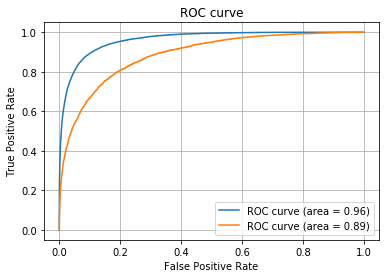

In [91]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred)
auc_train = metrics.auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred)
auc_val = metrics.auc(fpr_val, tpr_val)
print('------------------')
print(auc_train)
print(auc_val)

plt.plot(fpr_train, tpr_train, label='ROC curve (area = %.2f)'%auc_train)
plt.plot(fpr_val, tpr_val, label='ROC curve (area = %.2f)'%auc_val)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

plt.show

In [86]:
imp_mask = gbm.feature_importance() > gbm.feature_importance().mean()

In [87]:
X_train = X_train[:,imp_mask]
X_val = X_val[:,imp_mask]

In [ ]:
y_test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [ ]:
se_submission = pd.Series(y_test_pred, 'target')
df_sub = pd.concat([df_test['ID_code'], se_submission], axis=1)

In [ ]:
print(df_sub.shape)
print(df_sub.head())

In [ ]:
df_sub.to_csv('submission_var_score_lr.csv', index=False)